![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot

# Reconnaissance d'image
## Mise en situation
Je ne sais pas trop pourquoi, mais bon c'est un sujet récurrent dans les hands-on de machine learning : trouver un modèle qui reconnait les chiens et les chats.

Bon, pour démarrer ici, on va dire, juste les chats

## Utiliser un réseau profond
On va simplement utiliser notre réseau précédent et l'entrainer à reconnaître des chats :)

Le code est le même qu'hier.

In [2]:
# Les différentes fonctions
def sigmoid(x) : return 1 / (1 + np.exp(-x))
def tanh(x): return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
def relu(x): return np.maximum(x, 0)

act_functions = {'sigmoid': sigmoid, 'tanh' : tanh, 'relu' : relu}

# Leurs dérivées
def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def d_tanh(x):
    t = tanh(x)
    return 1 - t**2

def d_relu(x):
    return x > 0

act_derivates = {'sigmoid': d_sigmoid, 'tanh' : d_tanh, 'relu' : d_relu}

# Passe en avant : 1 couche - on utilise le dictionnaire de fonctions
def layer_forward_pass(X, W, b, activation):
    Z = np.dot(W, X) + b
    A = act_functions[activation](Z)
    return Z, A

# Passe en avant : toutes les couches
def model_forward_pass(X, activations, parameters):
    result = {}
    result['A0'] = X
    # Entrée de la première couche: X
    A = X
    for i in range(1, len(activations) + 1):
        # Pour chaque couche, une passe en avant. Les W et b viennent de parameters
        Z_next, A_next = layer_forward_pass(A, parameters['W' + str(i)], parameters['b' + str(i)], activations[i-1])
        result['Z' + str(i)] = Z_next
        result['A' + str(i)] = A_next
        A = A_next
    return result

# Passe en arrière : 1 couche - on utilise le dictionnaire de dérivées
def layer_backward_pass(dA, Z, A_prev, W, activation):
    dZ = dA * act_derivates[activation](Z)
    dW = np.dot(dZ, A_prev.T)
    db = np.sum(dZ, axis=1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    return dW, db, dA_prev

# Passe en arrière : toutes les couches
def model_backward_pass(dA_last, parameters, forward_pass_results, activations):
    gradients = {}
    dA = dA_last
    for i in range(len(activations), 0, -1):
        dW, db, dA_prev = layer_backward_pass(dA,
                                              forward_pass_results['Z' + str(i)],
                                              forward_pass_results['A' + str(i-1)],
                                              parameters['W' + str(i)],
                                              activations[i-1])
        gradients['dW' + str(i)] = dW
        gradients['db' + str(i)] = db
        dA = dA_prev
    return gradients

def train_model(X, Y, layer_dimensions, layer_activations,
               learning_rate = 0.01, epochs = 10, batch_size = 64,
               show_cost = False):
    
    m = X.shape[1]
    #Nombre de couches - hors celle des entrées
    l = len(layer_dimensions)-1
    
    # Création de tous les paramètres
    # A chaque étape, W a pour dimensions "nb neurones de la couche" x "nb entrées" - on parlera de la division plus tard
    # Et b est un vecteur, une valeur par neurone
    parameters = {}
    for i in range(1, l+1):
        parameters['W' + str(i)] = np.random.randn(layer_dimensions[i], layer_dimensions[i-1]) / np.sqrt(layer_dimensions[i-1])
        parameters['b' + str(i)] = np.zeros((layer_dimensions[i], 1))
    
    costs = []
    # Apprentissage
    for e in range(epochs):
        for s in range(0, m, batch_size):
            x_batch = X[:, s:s+batch_size]
            y_batch = Y[:, s:s+batch_size]
    
            # Passe en avant
            forward_pass_results = model_forward_pass(x_batch, layer_activations, parameters)
            
            # Calcul de la dérivée du coût par rapport au dernier A
            A_last = forward_pass_results['A' + str(l)]
            dA_last = -(np.divide(y_batch, A_last) - np.divide(1 - y_batch, 1 - A_last))/x_batch.shape[1]

            # Calcul des gradients - passe en arrière
            gradients = model_backward_pass(dA_last, parameters, forward_pass_results, layer_activations)
            
            # Descente de gradient
            for i in range(1, l+1):
                parameters['W' + str(i)] -= learning_rate * gradients['dW' + str(i)]
                parameters['b' + str(i)] -= learning_rate * gradients['db' + str(i)]
        
        # Un peu de debug
        model_result = model_forward_pass(X, layer_activations, parameters)['A' + str(l)]
        cost = np.squeeze(-np.sum(np.log(model_result) * Y + np.log(1 - model_result) * (1-Y))/m)
        costs.append(cost)
        if show_cost :
            if e % (epochs // 20) == 0: print('Epoch #%i: %s' % (e, cost))
    return parameters, costs

## Retour à la mise en situation

### Chargement des données

On va utiliser une base qui était le support d'un examen final d'une de mes formations - par Andrew Ng, deeplearning.ai sur Coursera.

Allez, on charge et on normalise :

In [3]:
def load(file): 
    data = np.load(file)
    return data['x'], data['y']

x_train, y_train = load('data/d20_train_data.npz')
x_test , y_test  = load('data/d20_test_data.npz')

mus    = x_train.mean(axis = 1, keepdims = True)
sigmas = x_train.std (axis = 1, keepdims = True)

x_train_norm = (x_train-mus)/sigmas
x_test_norm  = (x_test -mus)/sigmas

Les images sont des vecteurs de taille 12288 : chaque image fait 64x64 et on a les trois composantes R, G et B de chaque pixel. Total : 64 x 64 x 3 = 12288.

On va entraîner un modèle qui a déjà fait ses preuves sur le sujet.

Epoch #0: 0.7853240629461675
Epoch #150: 0.39098538925899795
Epoch #300: 0.29760105348900817
Epoch #450: 0.23368589407281923
Epoch #600: 0.18792749433687653
Epoch #750: 0.15269290007804975
Epoch #900: 0.1257585802280725
Epoch #1050: 0.10485017024475578
Epoch #1200: 0.08798085376242028
Epoch #1350: 0.07448111305101174
Epoch #1500: 0.06376749669936302
Epoch #1650: 0.05494496751547223
Epoch #1800: 0.04792892584914568
Epoch #1950: 0.04203727690310805
Epoch #2100: 0.037202963545460065
Epoch #2250: 0.033224870997772465
Epoch #2400: 0.029818486916205953
Epoch #2550: 0.026841341850199464
Epoch #2700: 0.024274457927564497
Epoch #2850: 0.0222456842341318


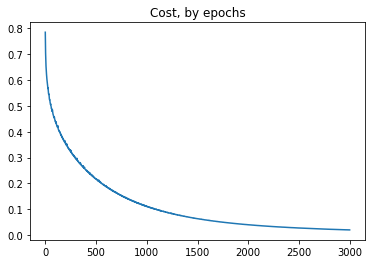

In [4]:
np.random.seed(1)
epochs = 3000
activations = ['relu', 'relu', 'relu', 'sigmoid']

params, costs = train_model(x_train_norm, y_train, [64*64*3, 20, 7, 5, 1], activations,
                            epochs = epochs, learning_rate = 0.0075, show_cost = True, batch_size = 256)

plot.plot(range(epochs), costs)
plot.title('Cost, by epochs')
plot.show()

Le coût décroit : ça signifie qu'au moins sur notre jeu d'entrainement, on est bon. Y'a plus qu'à tester !

In [5]:
def accuracy(x, y, params, layer_activations):
    results = model_forward_pass(x, layer_activations, params)['A'+str(len(layer_activations))] > .5
    return np.mean(results == y)

print('Accuracy on training set : %f%%' % (100*accuracy(x_train_norm, y_train, params, activations)))
print('Accuracy on test set : %f%%'     % (100*accuracy(x_test_norm , y_test , params, activations)))

Accuracy on training set : 100.000000%
Accuracy on test set : 74.000000%


On fait donc 100% sur le jeu de training, et 74% sur le jeu de test.
* Bon déjà reconnaître le test à 74% c'est déjà pas mal - on n'a **QUE** 200 images d'entraînement à disposition, c'est très peu, et c'est déjà prometteur quand même !
* Y'a un gros biais, il peut être du au modèle (pas assez complexe), à la distribution des données (les chats de tests ne ressemblent pas aux chats d'entrainement, par exemple j'ai appris avec des chats noirs uniquement et je teste avec des chats oranges rayés), ou à d'autres choses encore

Idéalement, l'étape suivante est de creuser pour essayer de comprendre les erreurs :
* les chats mal reconnus ressemblent bien à ceux de l'entraînement : c'est un overfit, à traiter comme tel
* les chats mal reconnus sont sensiblement différents : c'est un problème de distribution
* autre...

## Et c'est tout ?
Oui c'est tout. Un code pas vraiment compliqué quand on l'a écrit étape par étape, et on arrive à faire un truc correct.